In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [45]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.argmax(Q[observation])
        action_probs = np.ones(nA) * epsilon / nA
        action_probs[A] += 1 - epsilon
                
        return action_probs
    
    return policy_fn

In [87]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i in range(num_episodes):
        observation = env.reset()
        episode = []
        done = False
        while not done:
            action_probs = policy(observation)
            action = np.random.choice(len(action_probs), p=action_probs)
            next_observation, reward, done, _ = env.step(action)
            episode.append((observation, action, reward))
            observation = next_observation
                        
        visited = set()
        for j in range(len(episode)):
            sa = episode[j][:2]
            if sa not in visited:
                visited.add(sa)
                reward = sum(discount_factor**(k - j) * episode[k][2] for k in range(j, len(episode)))
                returns_sum[sa] = reward + returns_sum[sa] if sa in returns_sum else reward
                returns_count[sa] = returns_count[sa] + 1 if sa in returns_count else 1
        
        for sa in returns_sum.keys():
            Q[sa[0]][sa[1]] = returns_sum[sa] / returns_count[sa]
        
    return Q, policy

In [88]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

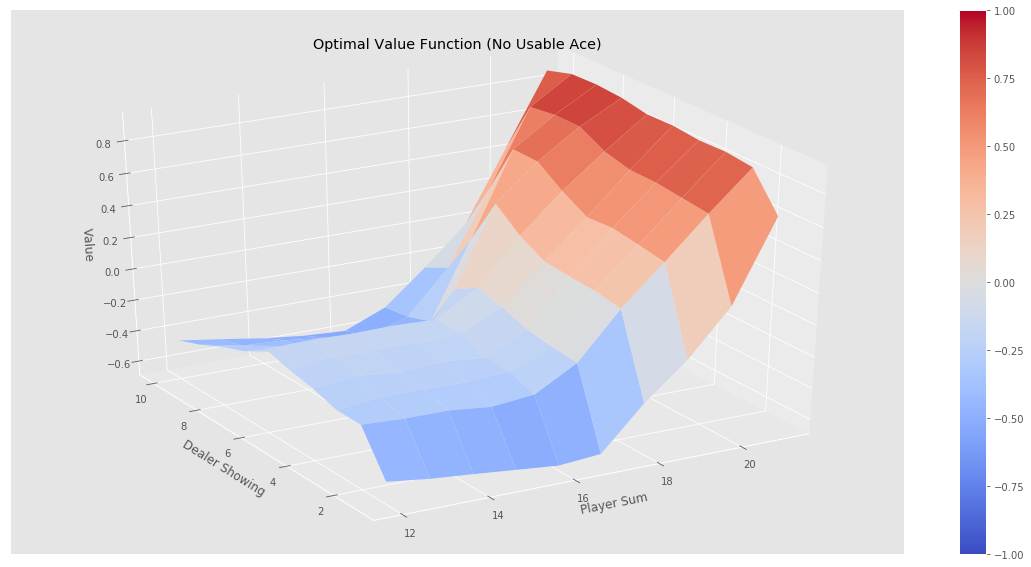

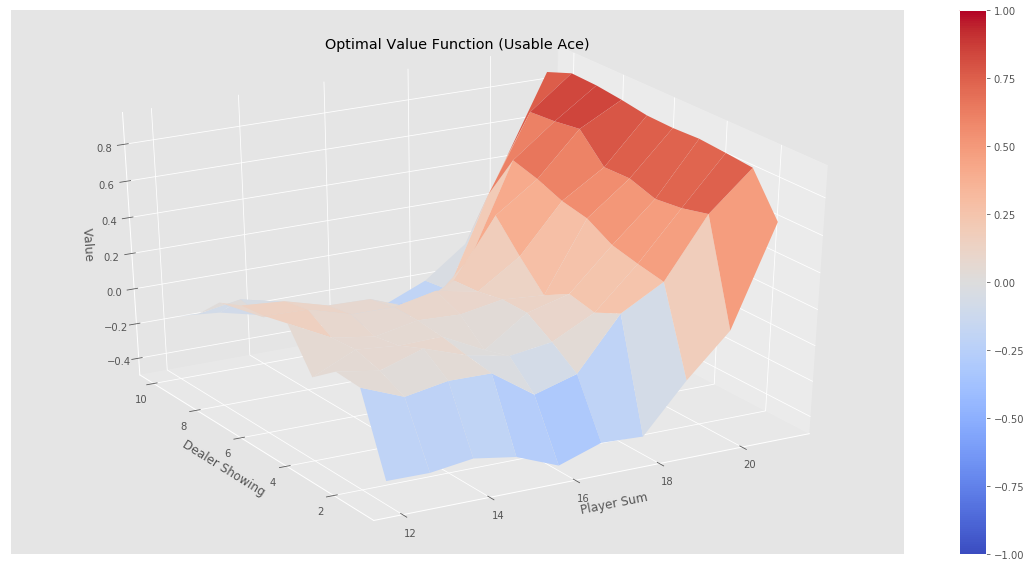

In [89]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [78]:
Q

defaultdict(<function __main__.mc_control_epsilon_greedy.<locals>.<lambda>()>,
            {(15, 1, False): array([0.        , 1.53664013]),
             (15, 3, False): array([0.        , 1.53076142]),
             (13, 6, False): array([0.        , 1.78408611]),
             (16, 3, False): array([0.       , 1.4272944]),
             (17, 7, True): array([0.        , 2.72953737]),
             (21, 8, False): array([0., 1.]),
             (17, 7, False): array([0.        , 1.33860393]),
             (21, 5, True): array([0.        , 2.22456462]),
             (20, 10, False): array([0.        , 1.07416531]),
             (13, 4, False): array([0.        , 1.77753401]),
             (19, 10, True): array([0.        , 2.45341615]),
             (19, 10, False): array([0.        , 1.14943052]),
             (16, 7, False): array([0.        , 1.42548553]),
             (20, 4, False): array([0.        , 1.07264722]),
             (18, 7, False): array([0.        , 1.23286385]),
         